# City Bikeshare System

**Hypothesis:**
- Registered users will more likely rent more bikes on weekdays compared to weekends/holidays.
- Casual users will rent more bikes on weekends/holidays.
- Bike rentals will most likey be highest during good weather (summer) and lowest during bad weather (weather).

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

**Reading Data:**

In [47]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [49]:
test_set['casual'] = 0
test_set['registered'] = 0
test_set['count'] = 0

data_set = pd.concat([train_set, test_set], axis=0)

In [51]:
data_set.info()
print()
data_set.head()

<class 'pandas.core.frame.DataFrame'>
Index: 17379 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      17379 non-null  int64  
 10  registered  17379 non-null  int64  
 11  count       17379 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1.7+ MB



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Visualizations:**

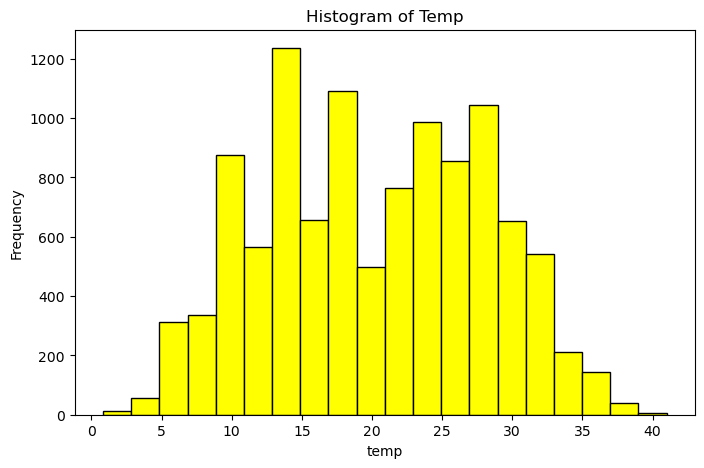

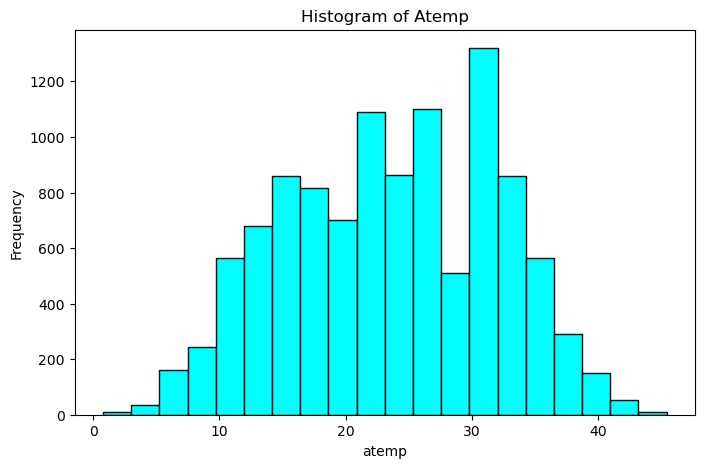

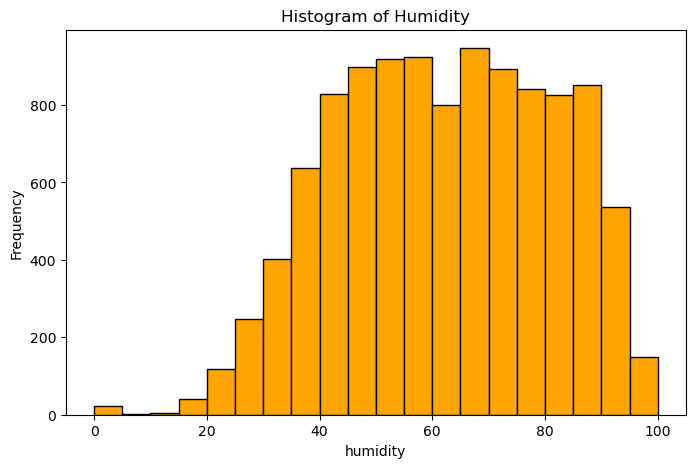

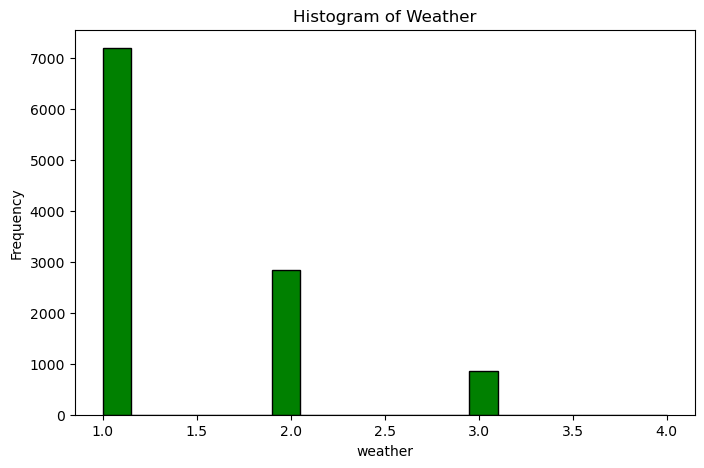

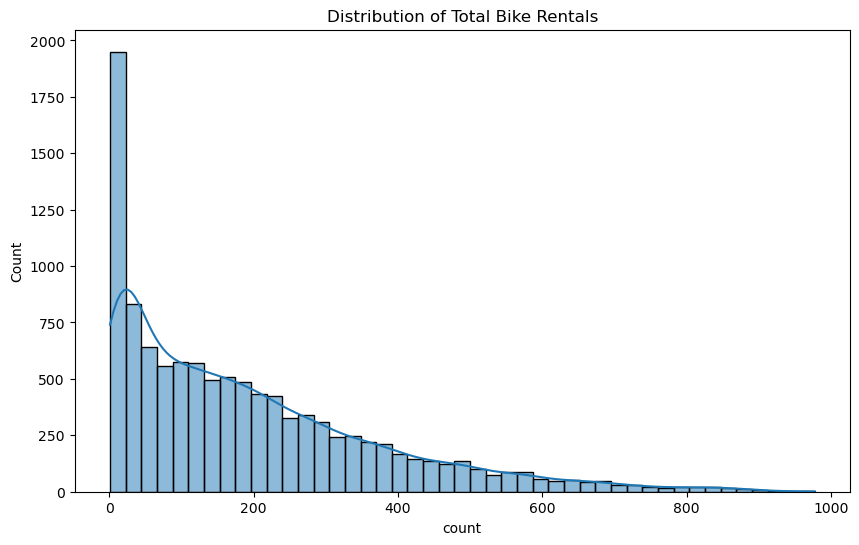

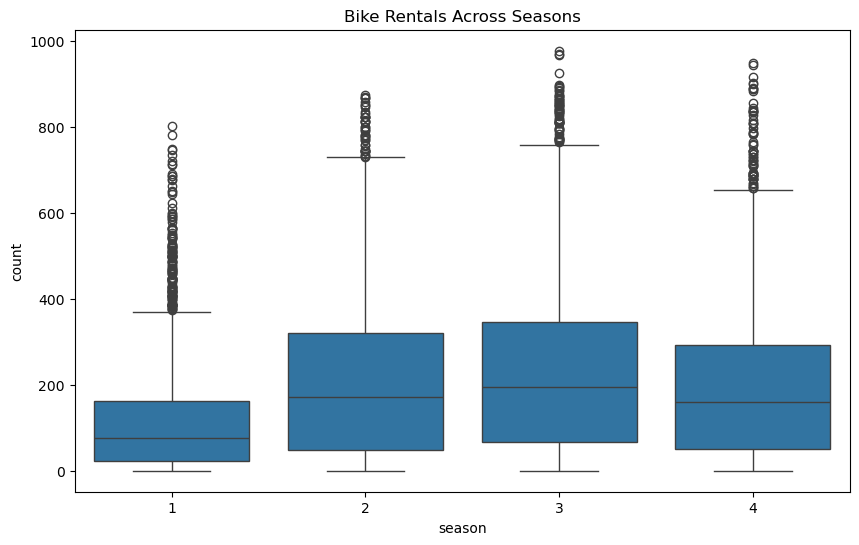

In [83]:
num_features = ['temp', 'atemp', 'humidity', 'weather']
colors = ['yellow', 'cyan', 'orange', 'green']

for feature, color in zip(num_features, colors):
    plt.figure(figsize=(8,5))
    plt.hist(train_set[feature], bins=20, color=color, edgecolor='black')
    plt.title(f'Histogram of {feature.capitalize()}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# Temp - Most temperatures are between 10C - 30C with a peak around 15C - 20C. Distribution seems to be skewed slightly toward lower temperatures.
# Atemp (feels-like temp) - Follows a similar pattern to actual temp peaking around 25C – 30C. Slightly more centered compared to real temperature.
# Humidity - Mostly high humidity around 40% - 90%, and a normal distribution. Very few days have humidity under 20%.
# Weather - Majority of days have clear/mostly clear weather (ex: category 1). Very few days have bad weather (like categories 3 and 4).



plt.figure(figsize=(10,6))
sns.histplot(train_set['count'], kde=True)
plt.title('Distribution of Total Bike Rentals')
plt.show()

# Most rental days have a low num of bikes rented (~200). Highly right-skewed and high rental counts are rare.



plt.figure(figsize=(10,6))
sns.boxplot(x='season', y='count', data=train_set)
plt.title('Bike Rentals Across Seasons')
plt.show()

# Median bike rentals are similar in all seasons, but number of outliers (high rental days) are pretty large. 
# Season 3 (Summer) slightly edges out others for higher rentals.

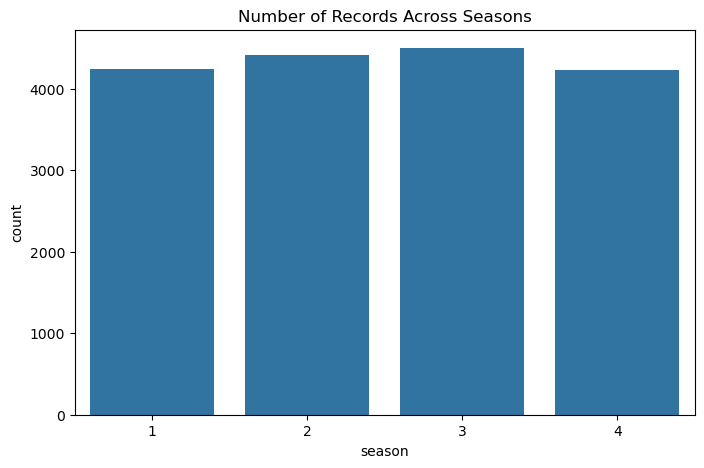

In [97]:
# Season Count
plt.figure(figsize=(8,5))
sns.countplot(x='season', data=data)
plt.title('Number of Records Across Seasons')
plt.show()

# Data is almost evenly spread out across all four seasons with very slight differences. 
# This means the dataset is mostly balanced seasonally — no major bias toward any specific season - proves hypothesis wrong.

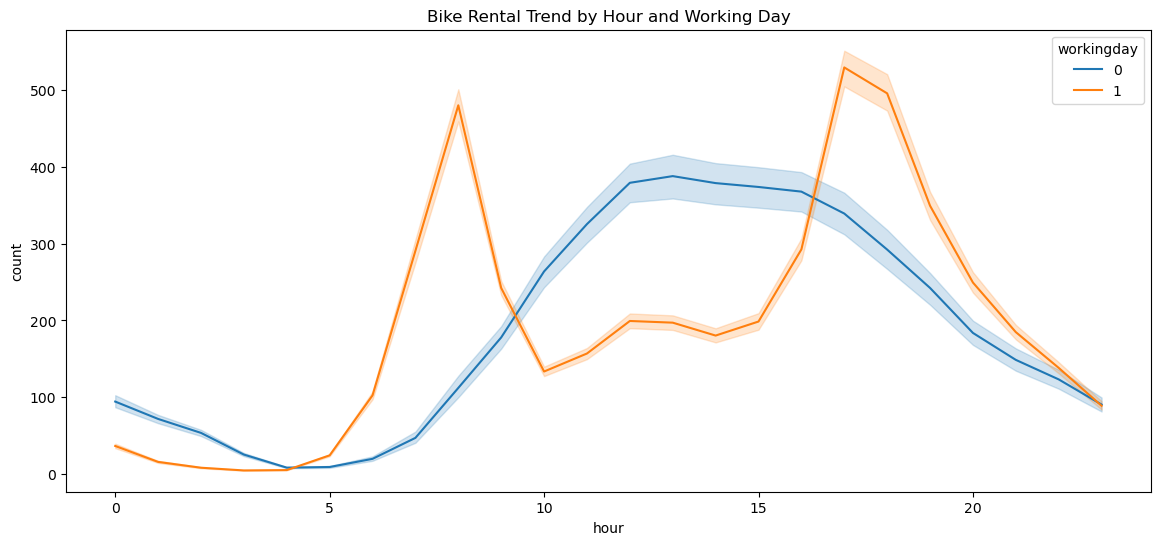

In [99]:
# Hourly and Workingday Trend
train_set['hour'] = pd.to_datetime(train_set['datetime']).dt.hour
plt.figure(figsize=(14,6))
sns.lineplot(data=train_set, x='hour', y='count', hue='workingday')
plt.title('Bike Rental Trend by Hour and Working Day')
plt.show()

# On working days (1), rentals peak around 8 AM and 5-6 PM - mostly due to commuting hours.
# On non-working days (0), rentals are more spread out increasing around 2-4 PM - afternoon leisure times.

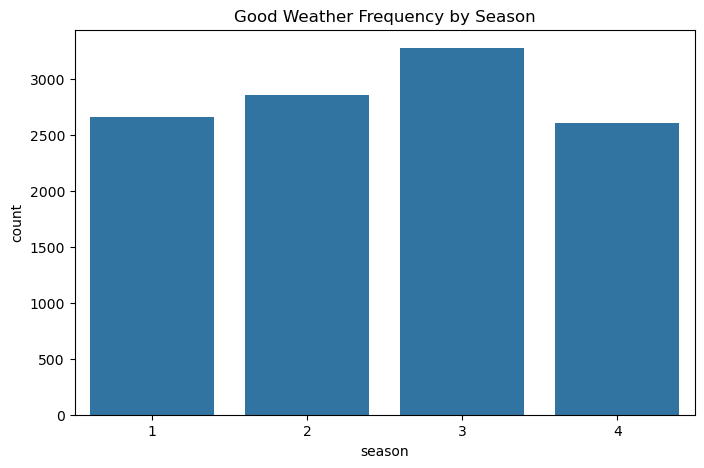

In [71]:
# Good Weather Frequency by Season
good_weather = data[data['weather'] == 1]
plt.figure(figsize=(8,5))
sns.countplot(x='season', data=good_weather)
plt.title('Good Weather Frequency by Season')
plt.show()

/var/folders/c3/7yl8004x2sg8z5ymrlxt6gs00000gn/T/ipykernel_99583/3117143196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_weather['hour'] = pd.to_datetime(good_weather['datetime']).dt.hour


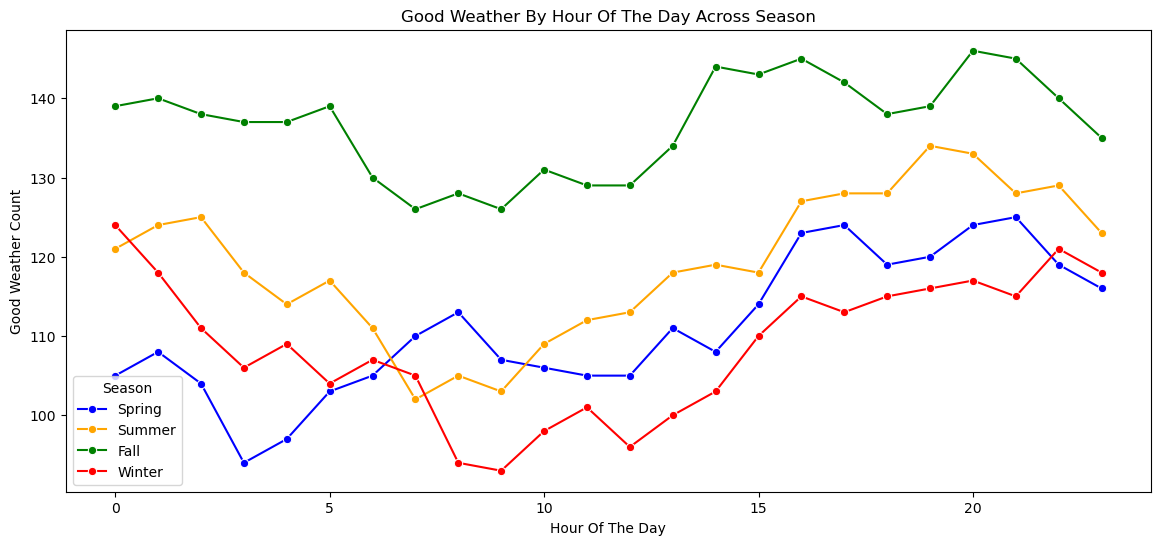

In [107]:
# Good Weather by Hour Across Seasons
good_weather['hour'] = pd.to_datetime(good_weather['datetime']).dt.hour
good_weather_season = good_weather.groupby(['hour', 'season']).size().reset_index(name='count')

season_labels = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
good_weather_season['season'] = good_weather_season['season'].map(season_labels)

palette = {'Spring': 'blue', 'Summer': 'orange', 'Fall': 'green', 'Winter': 'red'}

plt.figure(figsize=(14,6))
sns.lineplot(data=good_weather_season, x='hour', y='count', hue='season', palette=palette, marker='o')
plt.title('Good Weather By Hour Of The Day Across Season')
plt.xlabel('Hour Of The Day')
plt.ylabel('Good Weather Count')
plt.legend(title='Season')
plt.show()

# Good Weather is most frequent in fall as the green line is highest across almost all hours of the day compared to the other seasons

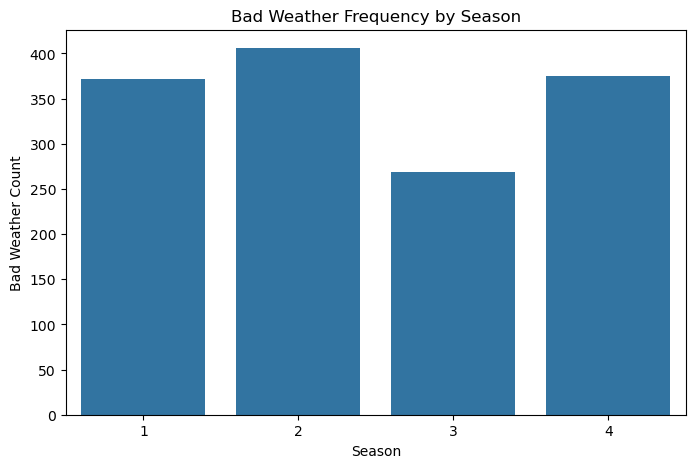

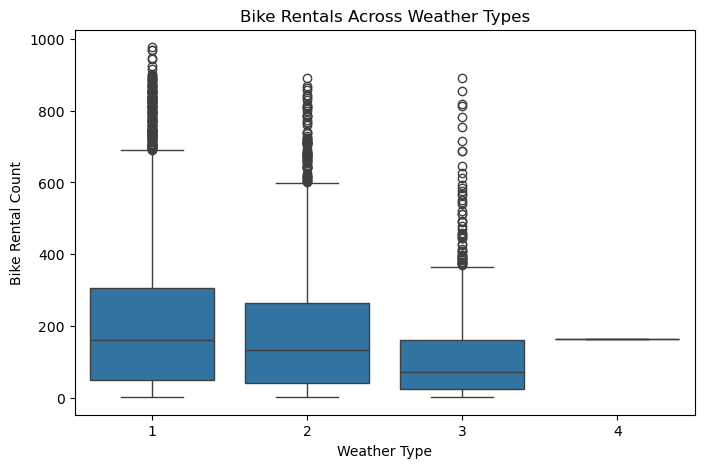

In [125]:
# Bad Weather Frequency by Season
bad_weather = data[data['weather'] >= 3]
plt.figure(figsize=(8,5))
sns.countplot(x='season', data=bad_weather)
plt.title('Bad Weather Frequency by Season')
plt.xlabel('Season')
plt.ylabel('Bad Weather Count')
plt.show()
# Summer (2) has the highest bad weather days & fall (3) has the fewest bad weather days.


# Bike Rentals During Different Weather Types
plt.figure(figsize=(8,5))
sns.boxplot(x='weather', y='count', data=train_set)
plt.title('Bike Rentals Across Weather Types')
plt.xlabel('Weather Type')
plt.ylabel('Bike Rental Count')
plt.show()
# Rentals are highest when the weather is good (weather type 1) and drop as weather worsens.
# Very few rentals happen during the worst weather (type 4).

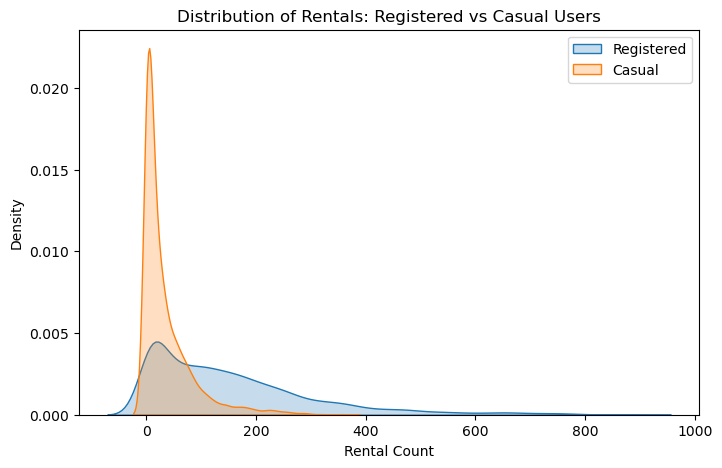

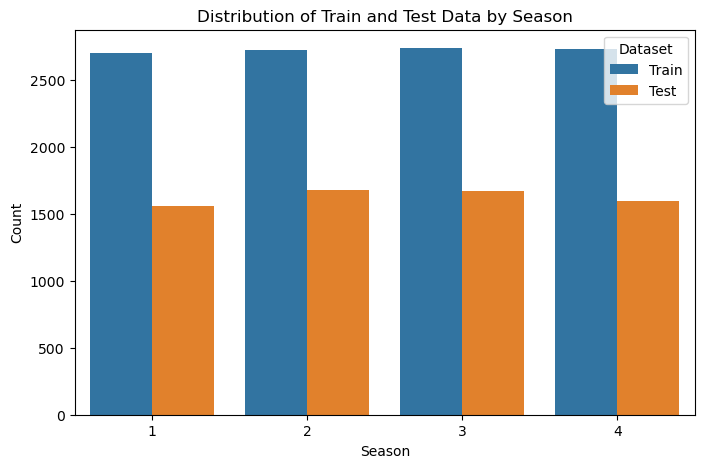

In [127]:
# Rentals: Registered vs Casual Users
plt.figure(figsize=(8,5))
sns.kdeplot(train_set['registered'], label='Registered', fill=True)
sns.kdeplot(train_set['casual'], label='Casual', fill=True)
plt.title('Distribution of Rentals: Registered vs Casual Users')
plt.xlabel('Rental Count')
plt.ylabel('Density')
plt.legend()
plt.show()
# Registered users rent more bikes overall and have a wider spread of rental counts whereas casual users mostly rent at 
# lower counts.


# Distribution of Train and Test Set by Season
train_set['dataset_type'] = 'Train'
test_set['dataset_type'] = 'Test'
combined = pd.concat([train_set, test_set], axis=0)
combined['season'] = pd.to_datetime(combined['datetime']).dt.month%12 // 3 + 1

plt.figure(figsize=(8,5))
sns.countplot(x='season', hue='dataset_type', data=combined)
plt.title('Distribution of Train and Test Data by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend(title='Dataset')
plt.show()
# Both train and test datasets are evenly distributed in all four seasons - no major bias between both sets
# so its good for modeling

**Scaling and Preprocessing:**

Scaling the dataset is beneficial as it normalizes features and improves the model's performance. I will use the standard scaler 
because the data (like temperature, humidity) is mostly normally distributed.  

Preprocessing Steps:

- Datetime:
  Have new features (hr, day, month) from the datetime column as these features influence bike rental patterns. Next, I dropped the original datetime column since it is no longer needed.

- Casual and Registered:
  I dropped casual and registered columns because these are not available in the original dataset. Also, my goal is to predict the total count, not the individual user types separately.

- Scaling:
  Continuous features like temp, atemp, windsped, and humidity are scaled using StandardScale to normalize the data and help models perform better.

- Handling Missing Columns: 
  In the test set, missing columns like casual, registered, and count are added with default values so that the training and testing data could be concatenated for exploration.



In [139]:
# Feature Engineering
def feature_engineering(df):
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    df['day'] = pd.to_datetime(df['datetime']).dt.day
    df['month'] = pd.to_datetime(df['datetime']).dt.month
    df.drop(['datetime', 'casual', 'registered'], axis=1, inplace=True, errors='ignore')
    return df

train_df = train_set.copy()
train_df = feature_engineering(train_df)

# Drop 'dataset_type' if it exists
train_df = train_df.drop(columns=['dataset_type'], errors='ignore')

X = train_df.drop('count', axis=1)
y = train_df['count']

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


**Model Creation**

Linear Regression: I chose LR because it is simple, fast, and interpretable model that can work really well when there is a linear relationship between features and the outcome.  
  - Performance: RMSLE = 1.2701 
  - Type: This is a parametric model as it has a linear relationship between inputs and output.
  
Random Forest Regressor: I chose Random Forest because it is a strong and flexible model that can capture non linear patterns. It handles feature importance naturally and is robust to outliers.  
  - Performance: RMSLE = 0.4242
  - Type: This is a non-parametric model as it makes no assumptions about the underlying data distribution.

Most Important Features (from RF feature importance):
- hour: Rental counts vary heavily by time of day.
- temp/atemp: Temperature greatly influences bike usage.
- humidity: Extremely humid conditions likely reduce rentals.
- workingday: Different patterns on weekdays vs weekends.


Linear Regression RMSLE: 1.2701
Random Forest Regressor RMSLE: 0.4242


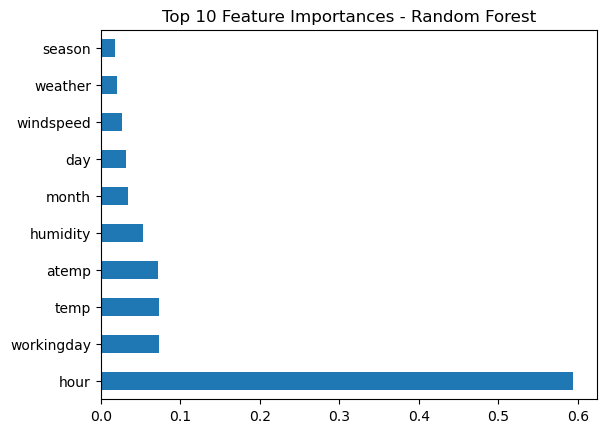

In [150]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)  # Use unscaled X
y_pred_lr = lr.predict(X_val)
y_pred_lr = np.maximum(0, y_pred_lr)  # Clip negatives to zero

rmse_lr = np.sqrt(mean_squared_log_error(y_val, y_pred_lr))
print(f'Linear Regression RMSLE: {rmse_lr:.4f}')

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
y_pred_rf = np.maximum(0, y_pred_rf)  # Clip negatives to zero

rmse_rf = np.sqrt(mean_squared_log_error(y_val, y_pred_rf))
print(f'Random Forest Regressor RMSLE: {rmse_rf:.4f}')

# Feature Importance (for RF)
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()


**Conclusion**
- Random Forest outperformed Linear Regression with a lower RMSLE.
- Important features included 'hour', 'temp', 'atemp', and 'humidity'.
- Linear Regression is a **parametric** model (that assumes linearity), Random Forest is **non-parametric** (no assumptions).
- Bike rental count is highly dependent on time of day, temperature, and working days.

I learned that feature engineering (like extracting 'hour') greatly improves model accuracy, and non-linear models like Random Forest are better suited for complex patterns like bike rental demand.


I experimented with two models: Linear Regression and Random Forest Regressor. Linear Regression was chosen because it is simple, interpretable, and works well when there is a clear linear relationship between input features and the target variable. Random Forest was chosen for its ability to capture non-linear patterns and its robustness to outliers. After training and evaluation, Random Forest outperformed Linear Regression by achieving a lower RMSLE score, showing that it is a better predictive performance on this dataset. Linear Regression is a **parametric** model as it assumes a specific form for the data, whereas Random Forest is a **non-parametric** model that does not make strong assumptions about the data. Based on feature importance from Random Forest, the influencing features are 'hour', 'temp', 'atemp', and 'humidity'. Overall, this project hihglighted the importance of feature engineering and selecting flexible models when dealing with complex datasets.


